Simulate Asset Price Evolutions and Reprice Risky up-and-out Call Option 
The goal of this submission is to reprice the risky up-and-out call option from (Earlier project) Submission 1, but now implementing a non-constant interest rate and local volatility. With the exception of the interest rates and volatilities. We are going to make the same assumptions as in Submission 1: 

In [1]:
# IMPORTING THE RELEVANT LIBRARIES FOR THE CODE

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import ncx2
import pandas as pd
import scipy.optimize

In [2]:
# INPUT DATA

#Share specific information
S0 = 100
v0 = 0.06
sigma_stock = 0.3   #share price constant volatility 30%


#Up-and-Out Call Option
K = 100 # Strike price. The option is struck at-the-money, therefore, K=S_0
k_log = np.log(K)
H = 150 # barrier price
T = 1   # maturity of 1 year
t = np.linspace(0,12,13)
time_step = len(t)
dt = T/time_step


#Firm Specific Information
V0 = 200  # Current firm value. Assumed to be 200
sigma_firm = 0.25 # volatility 25%
debt = 175  # T_debt = 1
recovery_rate = 0.25 # recovery rate
correlation = 0.2 # correlation between the counterparty and the stock is constant at 0.2

#Market information
r = 0.08    #risk-free continuously-compounded rate

#Additional information
gamma = 0.75
simulation = 100000


## Task 1 :  Simulating the paths
Using a sample size of 100000, jointly simulate LIBOR forward rates, stock paths, and counterparty firm values. You should simulate the values monthly, and should have LIBOR forward rates applying over one month, starting one month apart, up to maturity. You may assume that the counterparty firm and stock values are uncorrelated with LIBOR forward rates

Text(0, 0.5, 'Compounded Interest Rate')

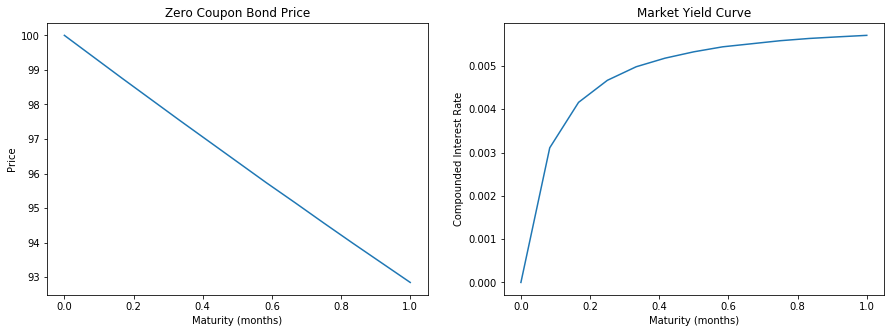

In [3]:
# STEP 1: Finding the market yield curve given by zero-coupon bond prices;

ZCB_prices  = {'Maturity':[0, 1/12, 2/12, 3/12, 4/12, 5/12, 6/12, 7/12, 8/12, 9/12, 10/12, 11/12, 1],
'Price':[100,99.38,98.76,98.15,97.54,96.94,96.34,95.74,95.16,94.57,93.99,93.42,92.85]}
#ZCB = pd.DataFrame(ZCB_prices, columns = ['Maturity', 'Price'])
ZCB = pd.DataFrame(ZCB_prices)

# Extract the Bond Prices and Timeline as Numpy arrays
bond_prices = ZCB['Price'].to_numpy()
time_line = ZCB['Maturity'].to_numpy()

#The forward Interest Rates
ZCB['Compounded Interest Rate'] = [np.log(100/i)/(ZCB[ZCB['Price']==i].index.values.astype(int)[0]+1) for i in ZCB['Price']]


# Plotting results
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(ZCB['Maturity'], ZCB['Price'])
plt.title("Zero Coupon Bond Price")
plt.xlabel("Maturity (months)")
plt.ylabel("Price")

plt.subplot(1,2,2)
plt.plot(ZCB['Maturity'],ZCB['Compounded Interest Rate'])
plt.title("Market Yield Curve")
plt.xlabel("Maturity (months)")
plt.ylabel("Compounded Interest Rate")

In [4]:
# FUNCTION DEFINITION

# Function payoff:
def call_payoff(Smax, S_T , K , H):
    """Function for evaluating the call price in Monte Carlo Estimation"""
    if Smax > H:
        return 0
    else:
        return np.maximum(S_T-K,0)
    
# Compounded interest rates
def int_rate(L,dt):
    """Function that calculates compounded interest from Libor rate and time interval"""
    return np.log(1+L*dt)/dt

# Local volatility function
def local_vol(sigma,gamma, St):
    """Function that calculates local volatility for a certain moment given its value at that time"""
    return sigma*(St**(gamma-1))

# Value Path Function 
def value_path(sigma, gamma, L, dt, z, St):
    """Function that simulates the next step in an asset´s price path"""
    return St*np.exp(((int_rate(L,dt)-((local_vol(sigma,gamma,St)**2)/2))*dt)+(local_vol(sigma,gamma,St)*np.sqrt(dt)*z))


In [5]:
# MAIN CODE

# Libor forward rate simulation
"""We assume that interest rate is uncorrelated with firm value and stock price so we can simulate interest rate separately"""
sigmaj = 0.2
np.random.seed(0)
bond_prices = bond_prices

mc_forward = np.ones([simulation, time_step-1])*(bond_prices[:-1]-bond_prices[1:])/(2*bond_prices[1:])
predcorr_forward = np.ones([simulation, time_step-1])*(bond_prices[:-1]-bond_prices[1:])/(2*bond_prices[1:])
predcorr_capfac = np.ones([simulation, time_step])
mc_capfac = np.ones([simulation, time_step])

delta = np.ones([simulation, time_step-1])*(t[1:]-t[:-1])

for i in range (1,time_step):
    z = norm.rvs(size = [simulation, 1])
    
    # Explicit Monte Carlo simulation
    muhat = np.cumsum(delta[:,i:]*mc_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*mc_forward[:,i:]),axis = 1)
    mc_forward[:,i:] = mc_forward[:,i:]*np.exp((muhat-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*z)
    
    # Predictor-Corrector Monte Carlo simulation
    mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*predcorr_forward[:,i:]),axis=1)
    for_temp = predcorr_forward[:,i:]*np.exp((mu_initial-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*z)
    mu_term = np.cumsum(delta[:,i:]*for_temp*sigmaj**2/(1+delta[:,i:]*for_temp),axis=1)
    predcorr_forward[:,i:] = predcorr_forward[:,i:]*np.exp((mu_initial+mu_term-sigmaj**2)*delta[:,i:]/2+sigmaj*np.sqrt(delta[:,i:])*z)
    
# Implying capitalisation factors from the forward rates
mc_capfac[:,1:] = np.cumprod(1+delta*mc_forward, axis = 1)
predcorr_capfac[:,1:] = np.cumprod(1+delta*predcorr_forward, axis = 1)

# Inverting the capitalisation factors to imply bond prices (discount factors)
mc_price = mc_capfac**(-1)
predcorr_price = predcorr_capfac**(-1)

# Taking averages
mc_final = np.mean(mc_price,axis = 0)
predcorr_final = np.mean(predcorr_price,axis = 0)

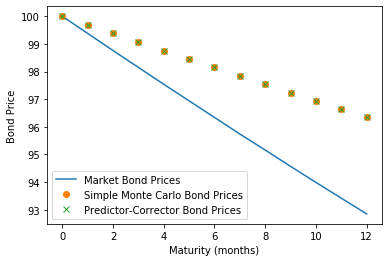

In [6]:
# PLOTTING RESULTS

plt.xlabel("Maturity (months)")
plt.ylabel("Bond Price")
plt.plot(t,bond_prices, label = "Market Bond Prices")
plt.plot(t,mc_final*100,'o', label = "Simple Monte Carlo Bond Prices")
plt.plot(t,predcorr_final*100,'x', label = "Predictor-Corrector Bond Prices")
plt.legend()
plt.show()


In [7]:
# Correlation matrix
corr_mat = np.array([[1,correlation],[correlation,1]])

# Create matrix of share price (For each timestep of each simulation):
share_path = np.zeros([simulation,time_step])

# Creat matrix of firm value (For each timestep of each simulation):
firm_path = np.zeros([simulation,time_step])

# Vectorize payoff, maximum stock price and terminal value of firm:
payoff = np.zeros([simulation])
discount_payoff = np.zeros([simulation])
share_max = np.zeros([simulation])
term_firm_val = np.zeros([simulation])
amount_loss = np.zeros([simulation])


# Stock price and firm value simulation:

for i in range (simulation):
    #We set initial value of share price and firm
    share_path[i,0] = S0
    firm_path[i,0] = V0
    
    # We use Cholesky decomposition to generate correlated random number
    norm_matrix = norm.rvs(size = np.array([2,time_step]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_mat),norm_matrix)
    
    # We calculate the path for the Share and Firm
    for j in range (1, time_step):
        share_path[i,j] = value_path(sigma_stock,gamma,mc_forward[i,j-1],dt,corr_norm_matrix[0,j],share_path[i,j-1])
        firm_path[i,j] = value_path(sigma_firm,gamma,mc_forward[i,j-1],dt,corr_norm_matrix[1,j],firm_path[i,j-1])

     
    # We extract results
    term_firm_val[i] = firm_path[i, time_step-1]
    
    # Calculate payoff for the option
    share_max[i] = max(share_path[i,:])                 # Calculates maximum share price for each path
    payoff[i] = call_payoff(share_max[i], share_path[i,12], K, H)
    
    # We Calculate the one-year discount factor
    discount_payoff[i] = payoff[i]/ (1+sum(mc_forward[i,:])*dt)
    
    # We calculate loss amount
    amount_loss[i] = (1-recovery_rate)*(term_firm_val[i] < debt)*discount_payoff[i]/(1+sum(mc_forward[i,:])*dt)

    
# We extract results from the simulations
mean_share_path = np.mean(share_path, axis=0)
std_share_path = np.std(share_path, axis=0)/np.sqrt(simulation)

mean_firm_path = np.mean(firm_path, axis=0)
std_firm_path = np.std(firm_path, axis=0)/np.sqrt(simulation)

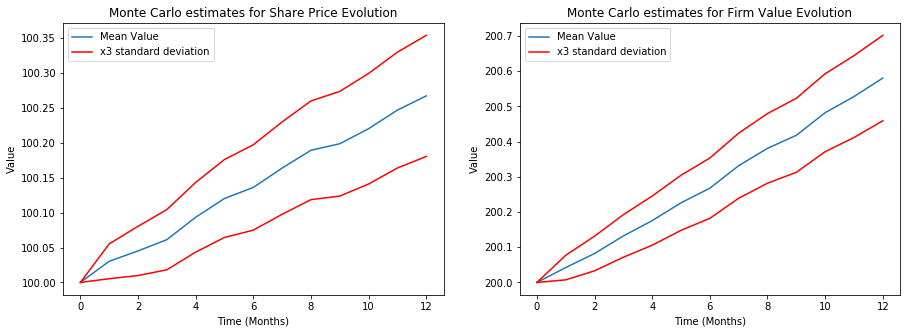

In [8]:
# PLOTTING RESULTS

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(mean_share_path, label = "Mean Value")
plt.plot(mean_share_path +3*np.array(std_share_path),'r', label = "x3 standard deviation")
plt.plot(mean_share_path -3*np.array(std_share_path),'r')
plt.title("Monte Carlo estimates for Share Price Evolution")
plt.xlabel("Time (Months)")
plt.ylabel("Value")
plt.legend()

plt.subplot(1,2,2)
plt.plot(mean_firm_path, label = "Mean Value")
plt.plot(mean_firm_path + 3*np.array(std_firm_path),'r', label = "x3 standard deviation")
plt.plot(mean_firm_path - 3*np.array(std_firm_path),'r')
plt.title("Monte Carlo estimates for Firm Value Evolution")
plt.xlabel("Time (Months)")
plt.ylabel("Value")
plt.legend()

plt.show()


### Task 2 : Valuing the option
Calculate the one-year discount factor which applies for each simulation, and use this to find first the value of the option for the jointly simulated stock and firm paths with no default risk, and then the value of the option with counterparty default risk. (Hint: you may want to use the reshape and ravel attributes of numpy arrays to ensure your dimensions match correctly.

In [9]:
# MAIN CODE

# We calculate Up and Out Call option price without CVA by taking average of discount_payoff
opt_risk_free_price = np.mean(discount_payoff)

# We calculate the CVA
cva_estimates = np.mean(amount_loss)

# We calculate the Up and Out Call option price taking into account CVA
Option_CVA = opt_risk_free_price - cva_estimates

In [14]:
# SHOWING RESULTS

print("CVA for this counterpart is: ", round(cva_estimates,6))
print("Option price without CVA is: ", round(opt_risk_free_price,6))
print("Option price with CVA is: ", round(Option_CVA,6))

CVA for this counterpart is:  0.02594
Option price without CVA is:  3.761695
Option price with CVA is:  3.735755
